In [1]:
import random

In [2]:
import numpy as np

In [3]:
import networkx as nx

In [4]:
import matplotlib.pyplot as plt

In [5]:
from collections import defaultdict

# Utility function to plot a graph

In [6]:
COLOR = ['r', 'b', 'g', 'c', 'm', 'y', 'k',
         '0.8', '0.2', '0.6', '0.4', '0.7', '0.3', '0.9', '0.1', '0.5']

def plot_nx_clusters(nx_graph, communities, position, figsize=(8, 8), node_size=200,
                     plot_overlaps=False, plot_labels=False):
    n_communities = min(len(communities), len(COLOR))
    plt.figure(figsize=figsize)
    plt.axis('off')
    fig = nx.draw_networkx_nodes(nx_graph, position, node_size=node_size, node_color='w')
    fig.set_edgecolor('k')
    nx.draw_networkx_edges(nx_graph, position, alpha=.5)
    for i in range(n_communities):
        if len(communities[i]) > 0:
            if plot_overlaps:
                size = (n_communities - i) * node_size
            else:
                size = node_size
            fig = nx.draw_networkx_nodes(nx_graph, position, node_size=size,
                                         nodelist=communities[i], node_color=COLOR[i])
            fig.set_edgecolor('k')
    if plot_labels:
        nx.draw_networkx_labels(nx_graph, position, labels={node: str(node) for node in nx_graph.nodes()})
    plt.show()

# Graph generation with the SBM model

In [7]:
def stochastic_block_model(membership_matrix, connectivity_matrix):
    n_nodes, n_coms = membership_matrix.shape
    parameters = np.matmul(membership_matrix, np.matmul(connectivity_matrix, membership_matrix.T))
    graph = nx.Graph()
    graph.add_nodes_from(range(n_nodes))
    for i in range(n_nodes):
        for j in range(i + 1, n_nodes):
            if random.random() < parameters[i, j]:
                graph.add_edge(i, j)
    return graph

In [8]:
def two_params_stochastic_block_model(community_sizes, din, dout):
    n_nodes = sum(community_sizes)
    n_coms = len(community_sizes)
    community_sizes = np.array(community_sizes)
    index = np.cumsum(community_sizes)
    communities = list()
    membership_matrix = np.zeros((n_nodes, n_coms))
    for k in range(n_coms):
        community = list((index[k - 1] % n_nodes) + range(community_sizes[k]))
        communities.append(community)
        membership_matrix[community, k] = 1
    connectivity_out = 1. * dout * n_nodes / (n_nodes * n_nodes - sum(community_sizes * community_sizes))
    connectivity_matrix = connectivity_out * np.ones((n_coms, n_coms))
    for k in range(n_coms):
        connectivity_matrix[k, k] = 1. * din / (community_sizes[k] - 1)
    graph = stochastic_block_model(membership_matrix, connectivity_matrix)
    return graph, communities, membership_matrix

In [9]:
nx_graph, gt_communities, gt_membership_matrix = two_params_stochastic_block_model([20, 20, 20, 20, 20], 9, .2)

In [10]:
pos = nx.spring_layout(nx_graph)

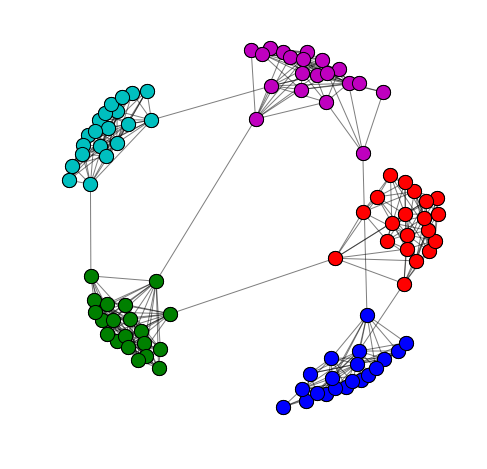

In [11]:
plot_nx_clusters(nx_graph, gt_communities, pos)

# Edge stream definition

In [12]:
edge_list = list()
for src, dst in nx_graph.edges():
    for i in range(30):
        edge_list.append((src, dst))
np.random.shuffle(edge_list)

# Streaming algorithm for graph clustering

In [13]:
v_max = 200

In [14]:
d = defaultdict(int)
c = defaultdict(int)
v = defaultdict(int)
k = 1
for i, j in edge_list:
    if c[i] == 0:
        c[i] = k
        k += 1
    if c[j] == 0:
        c[j] = k
        k += 1
    d[i] += 1
    d[j] += 1
    v[c[i]] += 1
    v[c[j]] += 1
    if v[c[i]] <= v_max and v[c[j]] <= v_max:
        if v[c[i]] <= v[c[j]]:
            v[c[j]] += d[i]
            v[c[i]] -= d[i]
            c[i] = c[j]
        else:
            v[c[i]] += d[j]
            v[c[j]] -= d[j]
            c[j] = c[i]

In [15]:
com_dict = defaultdict(set)
for i in c:
    com_dict[c[i]].add(i)
communities = list()
for com in com_dict.values():
    if len(com) > 1:
        communities.append(com)

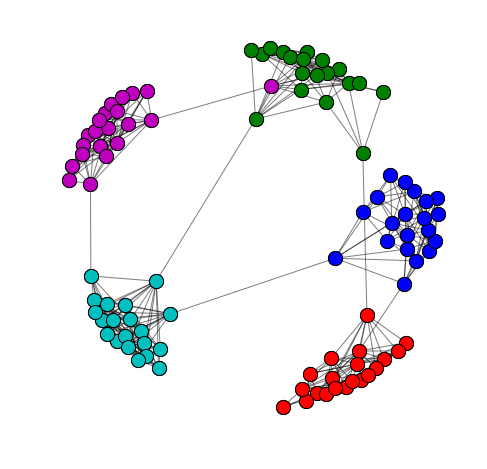

In [16]:
plot_nx_clusters(nx_graph, communities, pos)